Import de libs



In [24]:
import pandas as pd
import numpy as np
import seaborn as sns 

In [31]:
import matplotlib.pyplot as plt

Import de dados do kaggle

In [209]:
fires = pd.read_csv('database_fires.csv')

fires = fires.dropna()

fires = fires.reset_index(drop = True)

In [201]:
fires.head()

,id,estado,estacao,data,precipitacao,temp_max,temp_min,insolacao,evaporacao_piche,temp_comp_med,umidade_rel_med,vel_vento_med,altitude,fires
0,391,AC,88948,01/01/2017,44.2,30.0,22.5,2.8,2.1,25.76,93.5,0.666667,160.0,0
1,392,AC,88948,02/01/2017,8.8,32.8,22.5,4.5,1.1,25.88,94.0,0.000000,160.0,0
2,393,AC,88948,03/01/2017,5.0,30.2,23.3,1.4,1.5,25.40,96.0,1.000000,160.0,0
3,394,AC,88948,04/01/2017,3.8,31.4,22.1,6.5,0.9,26.14,91.0,0.500000,160.0,0
4,395,AC,88948,05/01/2017,18.3,30.0,22.7,3.5,1.7,25.00,96.0,0.000000,160.0,0


In [195]:
sem_na = fires.shape[0]

In [56]:
corrmat = fires.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(fires[top_corr_features].corr(),annot=True,cmap="RdYlGn")

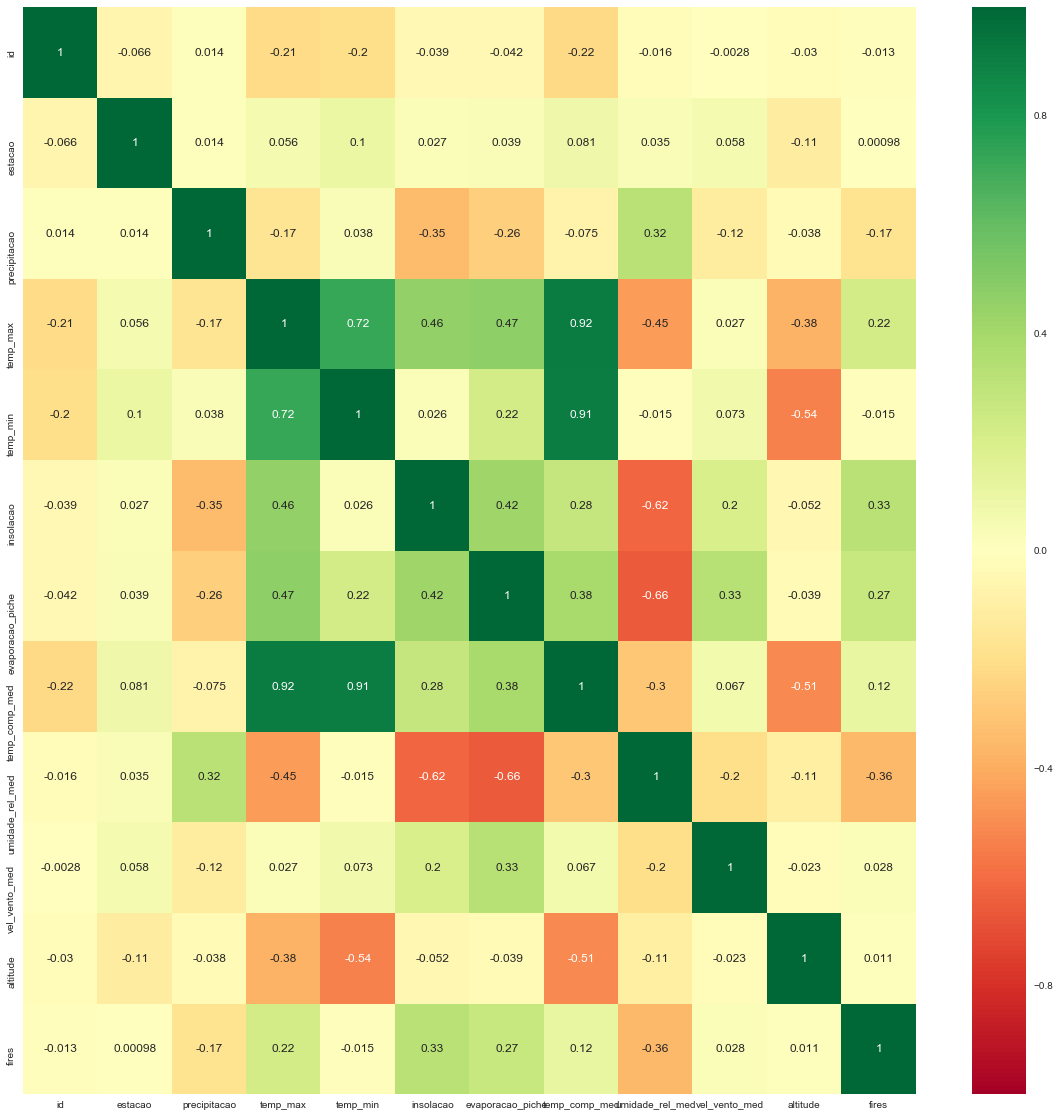

In [57]:
plt.show()

Mapa de correlação das colunas
As features temp_comp_med temp_max e temp_min tem correlação muito alta, pra mim, poderíamos tentar transformar essas três em apenas uma (fazendo uma nova coluna que é só a multiplicação das 3, por exemplo)
Sepa umid_rel_med insolacao e evaporacao_piche também vale a pena a gente fazer o mesmo (corr muito negativa)

### Tentativa de feature engineering

In [210]:
fires['temp_delta'] = fires['temp_max'] - fires['temp_min']

fires['temp_mult'] = fires['temp_max'] * fires['temp_min'] * fires['temp_comp_med']

fires['media_temp'] = (fires['temp_max']/3 + fires['temp_min']/3 + fires['temp_comp_med']/3)

In [71]:
corrmat = fires.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(fires[top_corr_features].corr(),annot=True,cmap="RdYlGn")

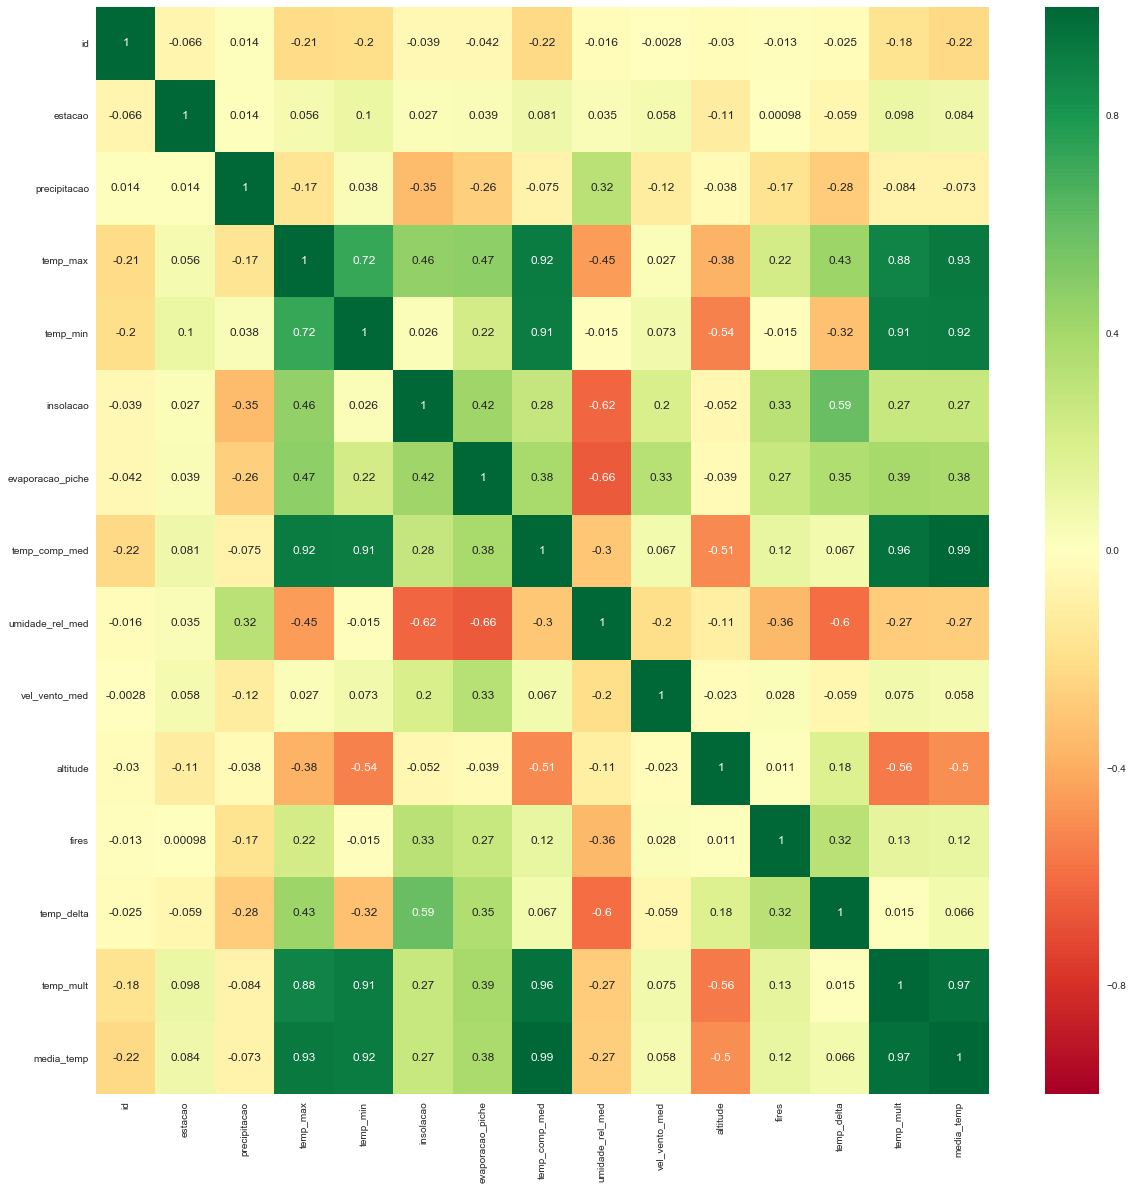

In [72]:
plt.show()

In [84]:
fires.head()

,id,estado,estacao,data,precipitacao,temp_max,temp_min,insolacao,evaporacao_piche,temp_comp_med,umidade_rel_med,vel_vento_med,altitude,fires,temp_delta,temp_mult,media_temp
0,391,AC,88948,01/01/2017,44.2,30.0,22.5,2.8,2.1,25.76,93.5,0.666667,160.0,0,7.5,17388.0000,26.086667
1,392,AC,88948,02/01/2017,8.8,32.8,22.5,4.5,1.1,25.88,94.0,0.000000,160.0,0,10.3,19099.4400,27.060000
2,393,AC,88948,03/01/2017,5.0,30.2,23.3,1.4,1.5,25.40,96.0,1.000000,160.0,0,6.9,17872.9640,26.300000
3,394,AC,88948,04/01/2017,3.8,31.4,22.1,6.5,0.9,26.14,91.0,0.500000,160.0,0,9.3,18139.5916,26.546667
4,395,AC,88948,05/01/2017,18.3,30.0,22.7,3.5,1.7,25.00,96.0,0.000000,160.0,0,7.3,17025.0000,25.900000


Por mim, podemos dropar a temp_comp_media e usar temp_max temp_min e o temp_delta pq não correlação alta com as outras features mas tem razoavelmente alta com a coluna de fires

As features de temp_mult e media_temp foram testes que eu achei ruim pq só replicaram as altas correlações que eu tava tentando tirar

In [211]:
fires = fires.drop(['temp_comp_med', 'temp_mult', 'media_temp'], axis = 1)

### Datas

Pra mim é uma feature super importante por questão de sazonalidade. Como sazonalidade independe do ano, pensei em criar duas outras colunas:
 - dia_ano: é uma coluna type Timestamp (pra ser contínuo) com dia e mês da linha mas tudo no mesmo ano
 - ano: ano da linha pq pode ser que um ano seja mais propício a ter incêndios que outro

In [212]:
fires['dia_ano'] = fires['data'].map(lambda x: pd.to_datetime(x[:-5] + '/2000', format = '%d/%m/%Y'))

fires['ano'] = fires['data'].map(lambda x: int(x[-4:]))

fires = fires.drop(['data'], axis = 1)

In [186]:
corrmat = fires.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(fires[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [220]:
fires.head()

,id,estado,estacao,precipitacao,temp_max,temp_min,insolacao,evaporacao_piche,umidade_rel_med,vel_vento_med,altitude,fires,temp_delta,dia_ano,ano
0,391,AC,88948,44.2,30.0,22.5,2.8,2.1,93.5,0.666667,160.0,0,7.5,2000-01-01,2017
1,392,AC,88948,8.8,32.8,22.5,4.5,1.1,94.0,0.000000,160.0,0,10.3,2000-01-02,2017
2,393,AC,88948,5.0,30.2,23.3,1.4,1.5,96.0,1.000000,160.0,0,6.9,2000-01-03,2017
3,394,AC,88948,3.8,31.4,22.1,6.5,0.9,91.0,0.500000,160.0,0,9.3,2000-01-04,2017
4,395,AC,88948,18.3,30.0,22.7,3.5,1.7,96.0,0.000000,160.0,0,7.3,2000-01-05,2017


### Encoding dos estados

Pra mim tem que ter um encoding relacionado a região, no mínimo. Podemos pensar em mais features vindas disso

In [208]:
### não fiz

### Rascunho de modelo

Usando XGBoost de árvores sem as variáveis categóricas por enquanto

In [250]:
base_rascunho = fires.drop(['id', 'estado', 'dia_ano', 'ano'], axis = 1)

In [299]:
y = pd.DataFrame(base_rascunho['fires'])
X = base_rascunho.drop(['fires'], axis = 1)

In [298]:
from sklearn.model_selection import train_test_split

In [300]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)

In [237]:
import xgboost as xgb
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score

In [304]:
param = {'eta': 0.15, 'max_depth': 3, 'objective': 'binary:logistic'}
param['eval_metric'] = 'auc'

steps = 20

#Transformando o df em DMatrix por causa do XGBoost
train = xgb.DMatrix(X_train, label=Y_train)

model = xgb.train(param, train, steps)

C:\Users\lucas\Anaconda3\lib\site-packages\xgboost\core.py:384: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


In [1]:
D_test = xgb.DMatrix(X_test, label=Y_test)

preds = model.predict(D_test)
best_preds = np.asarray([np.argmax(line) for line in preds])

print("Precision = {}".format(precision_score(Y_test, best_preds, average='macro')))
print("Recall = {}".format(recall_score(Y_test, best_preds, average='macro')))
print("Accuracy = {}".format(accuracy_score(Y_test, best_preds)))
print("AUC ROC = {}".format(roc_auc_score(Y_test, best_preds)))

NameError: name 'xgb' is not defined

In [311]:
roc_auc_score(Y_test, preds)

0.79299063283298843

Deu 80% de AUC sem fazer quase nada no modelo, acho que dá pra pegar uma porcentagem bem alta